# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, isnull, udf, last, first, struct, lit, approx_count_distinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import when as Fwhen
from pyspark.sql.functions import lag as Flag
from pyspark.sql.functions import isnull as Fisnull
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()
# Reduce number of partitions to only 5 to easily deal with small dataset
# as suggested at https://stackoverflow.com/questions/55721767/spark-streaming-job-is-running-very-slow
spark.conf.set("spark.sql.shuffle.partitions", 10)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Define path to the mini data set used for initial steps and load this data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
# Display data schema to get an idea of what the data looks like
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Looking at the schema we can observe that there is a total of 18 columns of which 12 are strings. Even out of those variables that are not strings only length really seems to be a classical numerical variable. One could perhaps also include the timestamp ("ts"), but as a data it should be dealt with differently than a quantitative variable. As for the other variables that are not integers, they really just represent some sort of ID and can therefore not be interpreted as numbers.

So, overall it seems as though we are dealing with mainly categorical variables.This will have certain implications later on once we deal with feature engineering. 

Let us also briefly note that there are some columns such as a user's first name where it is almost immediately obvious that they will most likely not help us with predicting user churn rates. We may thus be able to drop some columns later on.

In [301]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

## Looking for and Dealing with NANs
As a first step, let us have a look at how much data is actually missing and think about which columns are so critical that a missing value should lead to the exclusion of an observation.
The "userId" and the "ts" (timestamp) column may perhaps be the two most critical columns since these two columns ensure the integrity of an entry. Similarly, the 'sessionId' column should not have a missing value either.

In [190]:
# Used both isnan and isnull PySpark SQL functions as suggested at 
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
user_log.select([count(when(isnan(c), c)).alias(c) for c in user_log.columns]).show()
user_log.select([count(when(isnull(c), c)).alias(c) for c in user_log.columns]).show()
# Also look for cases with empty strings
user_log.select([count(when(col(c)=='', c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAge

In [220]:
# Have a closer look at the missing values
# For cases where we have no first name we would expect users not to be registered and hence to have no user ID
user_log.filter(isnull(user_log.firstName)).select('registration').dropDuplicates().show()
user_log.filter(isnull(user_log.firstName)).select('userId').dropDuplicates().show()
# For cases where there is no information on the artist or the song check if people were doing other things
# than listening to a song
user_log.filter(isnull(user_log.artist)).select('page').dropDuplicates().show(30, False)

+------------+
|registration|
+------------+
|        null|
+------------+

+------+
|userId|
+------+
|      |
+------+

+-------------------------+
|page                     |
+-------------------------+
|Downgrade                |
|Thumbs Down              |
|Login                    |
|About                    |
|Cancel                   |
|Add to Playlist          |
|Thumbs Up                |
|Home                     |
|Error                    |
|Save Settings            |
|Submit Downgrade         |
|Cancellation Confirmation|
|Register                 |
|Submit Registration      |
|Logout                   |
|Add Friend               |
|Settings                 |
|Roll Advert              |
|Help                     |
|Upgrade                  |
|Submit Upgrade           |
+-------------------------+



It turns out that there are two cases of missing values:
* 8346 rows of unregistered users (the "userId" column is empty and there is no personal user information,
i.e. first/ last name and gender available)
* 58,392 rows where users are not listening to a song and there is hence no song related information

As for the former, it seems reasonable to simply drop these rows since we only care about the churn of existing users. On the other side, missing song data is by no means a dealbreaker since in all cases where people are not listening to a song, we would not expect to get any song related information anyway.

In [5]:
# Drop rows with unregistered users
user_log = user_log.where(user_log.userId != '')

## Number of Observations and Distribution of Number of Interactions

In [112]:
# Explore dimensions after dropping NANs
num_obs = user_log.count()
num_cols = len(user_log.columns)
print('Number of observations: {}'.format(num_obs))
print('Number of columns:{}'.format(num_cols))
# Have a look at the number of unique user IDs and the average number of interactions per user ID
num_users = user_log.select('userId').dropDuplicates().count()
print('Number of unique users: {}'.format(num_users))
print('Average number of interactions per user {}'.format(num_obs/num_users))

Number of observations: 278154
Number of columns:18
Number of unique users: 225
Average number of interactions per user 1236.24


It turns out that what initially seemed like a rather larger data set is not that large because there were on average about 1236 interactions per user. Hence, the 278,154 interactions represent really just data of 225 unique users.  

Ultimately we want to use the log data to predict churn rates of individual users. Hence, we will ultimately need to aggregate the user log data at the user ID level to be able predict churn rates when we turn towards feature engineering and prediction. In this sense, we should probably think of the number of unique users as being more representative of our sample size.

Even so, it is also true that the more interactions we have recorded for each user the better we should be able to predict whether they will churn or not.

Next, let us have a brief look at how the number of interactions is distributed across the 225 unique users. 

In [95]:
user_log.filter(user_log.page == 'Cancellation Confirmation').count()

52

Median number of interactions per user: 848.0
Standard deviation of interactions per user: 1329.531716432519
Minimum number of interactions for a single user: 6
Maximum number of interactions for a single user: 9632


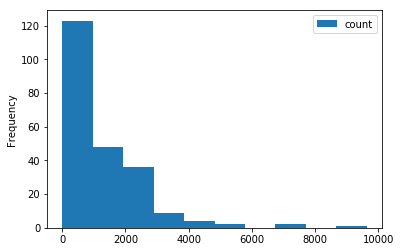

In [11]:
# Create a pandas dataframe with the distribution of the number of interactions and plot it
interactions_df = user_log.groupBy('userId').count().toPandas()
interactions_df.plot.hist()
print('Median number of interactions per user: {}'.format(interactions_df['count'].median()))
print('Standard deviation of interactions per user: {}'.format(interactions_df['count'].std()))
print('Minimum number of interactions for a single user: {}'.format(interactions_df['count'].min()))
print('Maximum number of interactions for a single user: {}'.format(interactions_df['count'].max()))

We can see that there is quite a lot of variability with respect to the number of interactions per user. This was probably to be expected. There will usually be some users who won't use  a service too much while others may actually be power users. As long as we have some interactions and as long as this difference in usage intensity is later on somehow reflected in our features, we will probably be fine.

Let us also have a brief look at gender and page to get a better overview of the collected data.

## Distribution of Gender and Page Accesses (Use of Different Functions of Service)

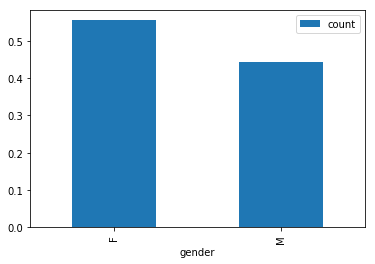

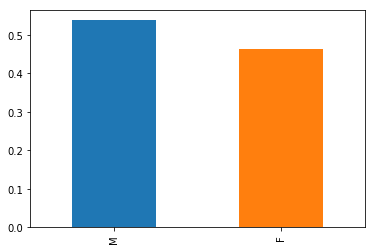

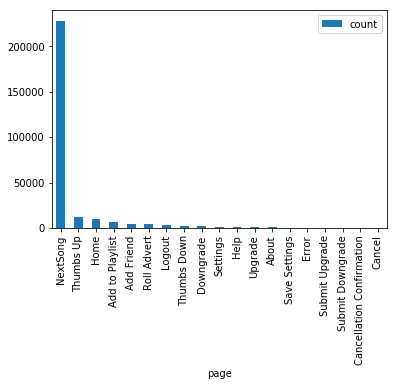

In [12]:
# Look at gender distribution in overall data, i.e. interactions
# I am using relative shares here for an easier comparison with the second case
# where gender distribution by user is plotted
gender_interaction_df = user_log.groupBy('gender').count().toPandas()
gender_interaction_df['count'] = gender_interaction_df['count']/num_obs
gender_interaction_df.plot.bar(x = 'gender')
plt.show()
# Look at gender distribution by user, i.e. how many users identified as male, female or did not provide an answer?
gender_user_df = user_log.groupBy('userId', 'gender').count().toPandas()
gender_user_df = gender_user_df['gender'].value_counts(normalize = True, dropna = False)
gender_user_df.plot.bar(x=gender_user_df.index)
plt.show()
# Have a look at how many interactions could be attributed to the different kinds of pages
# visited by users
page_df = user_log.groupBy('page').count().toPandas()
page_df.sort_values(by = 'count', ascending = False).plot.bar(x = 'page')

## Observations for Gender
Looking at the distribution of genders, we can see that while the share of women in overall interactions with Sparkify were larger (53.95%) while their share in users (46.02%) was actually smaller than that of men. This suggests that gender may be an interesting feature to consider later on. With that said, there does not seem be a huge imbalance in gender in the data regardless of which level we look at.

## Observations for Page
By far the most common interaction was "NextSong", i.e. users choosing a song to listen to. Given that Sparkify is a music streaming service this was probably to be expected, but it is still interesting to see how other activities like accessing the homepage of the service, giving a thumbs up for a song, adding songs to a playlist or adding friends happen much less frequently than playing back a song. 

## Distribution of Dates

Finally, before defining churn and looking at how users who have churned differ from those who have not, let us have a brief look at the distribution of dates in the data. To simplify things, I decided to simply look at year and month.

In [13]:
# Convert timestamps to year-month and save this in a new column 
ts_to_year_month = udf(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m'))
user_log = user_log.withColumn('year_month',ts_to_year_month(user_log.ts))

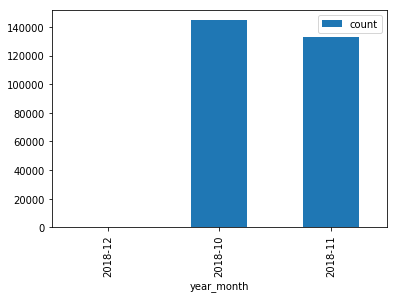

In [14]:
# Obtain pandas dataframe containing counts of year-month combinations and plot the result
year_month_df = user_log.groupBy('year_month').count().toPandas()
year_month_df.plot.bar(x = 'year_month')
plt.show()

It turns out that the Sparkify log data consists essentially of data collected in October 2018 and November 2018 in almost equal proportions (144,707 and 133,288 rows, respectively). There are also about 159 observations for December 2018.

In general, the more data we have the better, but overall user behaviour and preferences may change over time. Hence, if we were to use data collected over e.g. 5 years we would probably need to somehow account for these changes. In addition to this, changes in the service itself such as a new UI or changes in the content available may also cause data not to be comparable anymore. In fact, such changes could be the very reason for users to churn.

On the other hand, if the time period covered by our data is too short, this may also have a detrimental effect on the predictive power of our model. With this small dataset covering mostly only two months' worth of data, it could very well be possible that a lot of users only become tired of the service after three months or perhaps half a year.

Ultimately, while the data for this project was provided, in real life it could probably be rather important to think about how long the time period covered by the data should be.

# Defining Churn

### Strict Definition
Before we can move on to comparing users who churned and those who did not, we first need to think about what we would define as churning. A narrow definition would probably only include people who have deleted their account which is captured in our data as cases where the page feature takes on the value "Cancellation Confirmation", i.e. cases where people delete their account. This can happen for both users using the free or the paid version of the streaming service.

### A Broader View
If we take on a broader view, we could also think of users switching from the paid to the free service as doing some sort of churning. Both leaving the service It turns out that identifying these users is a bit more complicated. While a user can only cancel their registration once, it is very much possible for a customer to downgrade from the paid to the free service and to then upgrade to the paid service again or to even repeat this cycle. Ultimately, it seems most reasonable to only include people who have downgraded their account at least once in the observed time period in our data and whose level for the observation with the most recent time stamp was "free".

The question then is whether these two kinds of churning should be regarded as identical or whether we should really think of this as a multiclass-classification problem instead of a binary classification problem. Ideally, we should conduct a survey with users who canceled their registration and those who only switched from the paid to the free version of the service to gain some insights as to whether they are similar or quite different. This is obviously unfortunately not possible for this project. 

Looking at the available data, it turns out that if we also include users who just downgraded their accounts from paid to free, but still kept using the service many differences between the two groups of users become much less clear cut. Therefore, I decided not to include customers who merely downgraded their accounts. Besides, it seems reasonable to argue that the "economic damage" or decrease in revenues caused by users who merely downgraded their account is most likely much lower. It therefore seemed justifiable to me to only look at users who completely stopped using the service.

Finally, strictly speaking defining churn by just accounting for users who have canceled their account will quite likely underestimate actual churn rates. There may be users who perhaps never used the paid service and who stopped using the service, but never bothered to cancel their registration. Given that the data we have here only covers about two months, it is probably not reasonable to try to cover this problem, but it is certainly a point worth keeping in mind.

In [6]:
# Identify users who canceled their registration
flag_cancel = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log = user_log.withColumn('cancel_page',flag_cancel('page'))
windowval = Window.partitionBy('userId')
user_log = user_log.withColumn('churned',Fsum('cancel_page').over(windowval))

In [8]:
# Check if values of churned column are as expected, i.e. either 0 or 1
user_log.select('churned').dropDuplicates().show()

+-------+
|churned|
+-------+
|      0|
|      1|
+-------+



In [9]:
# Have a look at how many users have churned and how many have not
print('Number of users who have churned {}'.\
      format(user_log.filter(user_log.churned == 1).select('userId').dropDuplicates().count()))
print('Number of users who have not churned {}'.\
      format(user_log.filter(user_log.churned == 0).select('userId').dropDuplicates().count()))

Number of users who have churned 52
Number of users who have not churned 173


## Exploring Data: Comparing Users Who Churned and Those Who Did Not

Now that we have defined churn and identified those users who churned, we should have a look at some features and how their distribution differs across the two groups of users: those who have churned and those who have not.

In order to avoid potential issues and to also avoid repetition by having to apply all subsequent operations to two dataframes let us not create two different Pyspark dataframes, but rather perform the filtering later on when creating Pandas dataframes for our visualisations. This also means that we should create the required columns first before transferring the data to Pandas dataframes.

### Defining Features for Comparison
Now that we have created two separate dataframes, let us think about some measures we might be interested in. It seems reasonable to assume that users who churned used the service differently than those who did not. It may thus make sense to define some aggregate measures and compare their distributions across the two groups of users.

One at least to me intuitive approach would be to e.g. look at how much users of both groups did during a certain time period such as the latest two weeks for which data is available on them. It turns out that if you do this and look at how many times they did certain actions during that period of time, medians and means slightly differ, but overall distributions are very similar.

Instead, we could simply look at how much they did overall without restricting the period of time we are considering. We can then also have a look at things like how long their user sessions were on average to get a better understanding of their behaviour. 

I decided to look at the following aggregated metrics:
+ the total number of sessions of each user 
+ the average length of a user's sessions
+ the number of unique artists a user has listened to overall
+ the average number of songs listened to during a session
+ the average number of songs added to a playlist/ number of friends added during a session
+ the number of thumbs ups during a session
+ users' gender/ state
+ the difference between a user's date of registration and their last recorded activity as an indicator of how long they have
  used the service

In the following cells these measures are calculated and where necessary some additional explanations were added.

### Total Number of Sessions for Each User

As the first step, let us obtain the total number of sessions for each user. It turns out that we cannot use the approx_count_distinct PySpark SQL function here.

Instead we can take the following approach:
+ Using a window function obtain the previous sessionId for each user's previous row
+ Create a column indicating whether the session ID changed (we need to have it also display a 1 for the very first row)
+ Take the sum of "new_session" column to obtain the total number of sessions

In [14]:
# Create new column sessionId_prev using approach described at 
# https://www.arundhaj.com/blog/calculate-difference-with-previous-row-in-pyspark.html
prev_val_window = Window.partitionBy('userId').orderBy('ts')
user_log = user_log.withColumn('sessionId_prev',Flag(user_log.sessionId).over(prev_val_window))
user_log.head()

# create column 'new_session' (0 or 1)
new_session = udf(lambda session_ids: 1 if (session_ids[0] != session_ids[1]) & (session_ids[0] is not None) else 0, 
                  IntegerType())
# Create column indicating whether the session ID is new and also set it to 1 for the first session ID for
# each user which is the only case where the previous session ID column will have a value of null
user_log = user_log.withColumn('new_session',Fwhen(Fisnull(user_log.sessionId_prev), 1).\
                                                      otherwise(new_session(struct('sessionId_prev','sessionId'))))

user_log.head()

# Obtain total number of sessions for each user
user_log = user_log.withColumn('sessions_num', Fsum('new_session').over(windowval))
user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7)

### Average Session Length

We can now calculate the average lenght of a user's sessions by summing up the differences between the timestamps recorded during a session and dividing them by the number of total sessions. Note that we need to ignore the difference between the last timestamp of one session and the first timestamp of the next session in order not to count users' inactivity as activity. 

In [16]:
# Create Column containing timestamp from previous row
user_log = user_log.withColumn('ts_prev',Flag(user_log.ts).over(prev_val_window))
user_log.head()

# Calculate time elapsed since previous row in minutes using UDF only within sessions and not between them, i.e. only
# when the session ID is not different from the previous row
timedelta_udf = udf(lambda x: ((datetime.fromtimestamp(x[1]/1000) - datetime.fromtimestamp(x[0]/1000)).\
                    total_seconds()/60) if (x[0] is not None)&(x[2] != 1) else 0, DoubleType())
user_log = user_log.withColumn('ts_delta',Fwhen(Fisnull(user_log.ts_prev), 0).\
                               otherwise(timedelta_udf(struct('ts_prev','ts','new_session'))))

# Sum up total length of all sessions for each user
user_log = user_log.withColumn('total_time_sessions',Fsum('ts_delta').over(windowval))
user_log.head()

# Calculate average length of sessions
avg_time = udf(lambda x: x[0] / x[1], DoubleType())
user_log = user_log.withColumn('avg_session_lgth', avg_time(struct('total_time_sessions','sessions_num')))
user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335)

### Calculate Average Numbers of Activity Per Session
As we have just calculated the number of sessions above, we can now use this information to calculate how many times on average users performed certain activities during a single session.

In [17]:
# Define a UDF to subsequently create a new column indicating that a user performed an activity
flag_activity = udf(lambda column, activity: 1 if (column == activity) else 0, IntegerType())

# Create list containing names of new  flag columns to be created
flag_cols = ['song', 'home', 'thumbs_up', 'thumbs_down', 'add_playlist', 'add_friend', 'settings', 'help', 'error']
activities_list = ['NextSong','Home', 'Thumbs Up', 'Thumbs Down', 'Add to Playlist','Add Friend', 'Settings', 'Help', 'Error']

# Create the respective flag columns and calculate sums
# Again using approach as found at 
# https://stackoverflow.com/questions/47260999/how-to-pass-the-parameter-to-user-defined-function
# to pass in parameter to udf by defining a column containing a constant value -> lit(activity)
for activity,col_name in zip(activities_list, flag_cols):
    user_log = user_log.withColumn(col_name+'_flag', flag_activity('page', lit(activity)))

for col in flag_cols:    
    user_log = user_log.withColumn(col+'_num', Fsum(col+'_flag').over(windowval))

avg_per_session = udf(lambda numbers: numbers[0] / numbers[1], DoubleType())
    
for col in flag_cols:
    user_log = user_log.withColumn(col+'_avg_session', avg_per_session(struct(col+'_num', 'sessions_num')))

user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335, song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, song_num=275, home_num=11, thumbs_up_num=17, thumbs_down_num=5, add_playlist_num=7, add_friend_num=4, settings_num=0, help_num=2, error_num=0, s

### Calculating Total Usage Length
We can also have a look at for how long each user has been using the service since we have a column "registration" indicating the registration date of a user (again as a timestamp) and timestamps for each activity. One possible approach then is to look for the timestamp recorded for the last activity of a user and subtract from it the registration date.

In [19]:
# Take similar approach as above to obtain last value of timestamp for each user ID using approach found at 
# https://stackoverflow.com/questions/50468056/get-the-last-value-using-spark-window-function
window_level = Window.partitionBy("userId").orderBy("ts").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
user_log = user_log.withColumn('last_ts',last('ts').over(window_level))

# Define a UDF to calculate the difference in fractions of days between registration date and last date for which activity
# was observed
ts_diff_days = (lambda ts_struct: (datetime.fromtimestamp(ts_struct[1]/1000) - datetime.fromtimestamp(ts_struct[0]/1000)).\
                         total_seconds()/(24*3600))
ts_diff_udf = udf(ts_diff_days, DoubleType())

user_log = user_log.withColumn('usage_length',ts_diff_udf(struct('registration','last_ts')))
user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335, song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, song_num=275, home_num=11, thumbs_up_num=17, thumbs_down_num=5, add_playlist_num=7, add_friend_num=4, settings_num=0, help_num=2, error_num=0, s

### Calculating Unique Number of Artists
In this case we can make use of the approx_count_distinct function to obtain the number of unique artists a user listened to.

In [20]:
# Add column containing unique number of artists a user listened to using approx_count_distinct as explained at
# https://stackoverflow.com/questions/45869186/pyspark-count-distinct-over-a-window
user_log = user_log.withColumn('dist_num_artists', approx_count_distinct('artist').over(windowval))
user_log.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335, song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, song_num=275, home_num=11, thumbs_up_num=17, thumbs_down_num=5, add_playlist_num=7, add_friend_num=4, settings_num=0, help_num=2, error_num=0, s

### User Location
Depending on the location, users' preferences or their economic situation may differ. Hence, the location could also be an interesting feature to investigate. Since this is a categorical variable, we will ultimately, should we indeed use this feature, by using e.g. one-hot encoding need about as many columns as there are different locations. As it was included in this data, the location column contains both a user's city and the state they live in. To simlify this problem, let us just have a look at the state. We can do so by creating a new column containing just the two last characters of the location column.

In [23]:
# Create a column containing the state a user resides in
extract_state = udf(lambda location: location[-2:])
user_log = user_log.withColumn('state', extract_state('location'))
user_log = user_log.withColumn('num_states', approx_count_distinct('state').over(windowval))
print(user_log.head())
# Check if the number of unique values of the states is indeed just 1 for each user
user_log.select('num_states').dropDuplicates().show()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', cancel_page=0, churned=0, sessionId_prev=None, new_session=1, sessions_num=7, ts_prev=None, ts_delta=0.0, total_time_sessions=1081.3833333333334, avg_session_lgth=154.48333333333335, song_flag=1, home_flag=0, thumbs_up_flag=0, thumbs_down_flag=0, add_playlist_flag=0, add_friend_flag=0, settings_flag=0, help_flag=0, error_flag=0, song_num=275, home_num=11, thumbs_up_num=17, thumbs_down_num=5, add_playlist_num=7, add_friend_num=4, settings_num=0, help_num=2, error_num=0, s

## Comparing Features Across the Two Groups

Now that we have defined some features, let us compare their distributions across the two user groups. In order to do so, we will need to move the aggregated features to pandas dataframes. 

Given that we have a relatively small number of users in the dataset used for our exploratory data analysis we can just select the relevant aggregated columns and then drop the duplicates so that we end up with only row per user and then save the data in Pandas dataframes (one for each of the two groups). We can then look at the mean, median and standard deviation of these features for both groups and also visualise the different distributions. 

In [29]:
# Create a pandas dataframe for each user group containing the measures we are interested in
# Define the relevant columns in a list
cols_analysis = ['userId','sessions_num','dist_num_artists','avg_session_lgth','song_avg_session','home_avg_session', 
                 'thumbs_up_avg_session', 'thumbs_down_avg_session', 'add_playlist_avg_session', 'add_friend_avg_session', 
                 'settings_avg_session', 'help_avg_session', 'error_avg_session', 'usage_length', 'state', 'gender']
churned_df = user_log.filter(user_log.churned == 1).select(*cols_analysis).dropDuplicates().toPandas()
not_churned_df = user_log.filter(user_log.churned == 0).select(*cols_analysis).dropDuplicates().toPandas()

In [26]:
for col in ['sessions_num','dist_num_artists','avg_session_lgth','song_avg_session','home_avg_session', 
            'thumbs_up_avg_session', 'thumbs_down_avg_session', 'add_playlist_avg_session', 'add_friend_avg_session', 
            'settings_avg_session', 'help_avg_session', 'error_avg_session', 'usage_length']:
    print('median for '+str(col)+' for churned users : '+str(churned_df[col].median()))
    print('mean for '+str(col)+' for churned users : '+str(churned_df[col].mean()))
    print('sd for '+str(col)+' for churned users : '+str(churned_df[col].std()))
    print('median for '+str(col)+ ' for users who have not churned : '+ str(not_churned_df[col].median()))
    print('mean for '+str(col)+' for users who have not churned : '+str(not_churned_df[col].mean()))
    print('sd for '+str(col)+' for users who have not churned : '+str(not_churned_df[col].std()))
    print('\n')

median for sessions_num for churned users : 8.5
mean for sessions_num for churned users : 10.326923076923077
sd for sessions_num for churned users : 8.61080295917924
median for sessions_num for users who have not churned : 11.0
mean for sessions_num for users who have not churned : 15.254335260115607
sd for sessions_num for users who have not churned : 15.866963127421297


median for dist_num_artists for churned users : 396.0
mean for dist_num_artists for churned users : 526.1923076923077
sd for dist_num_artists for churned users : 458.1856819624053
median for dist_num_artists for users who have not churned : 615.0
mean for dist_num_artists for users who have not churned : 752.0751445086705
sd for dist_num_artists for users who have not churned : 637.8203801570855


median for avg_session_lgth for churned users : 213.5941666666668
mean for avg_session_lgth for churned users : 259.57453028914773
sd for avg_session_lgth for churned users : 184.29980901838726
median for avg_session_lgth f

### Identifying Interesting Features

By looking at the above values, we can easily identify some features which may be interesting for our machine learning model(first values in parentheses refer to churners while the second refer to non-churners):
+ Number of sessions (**sessions_num**): Both the median (8.5 vs. 11.0) and the mean (10.33 vs 15.25) are noticeably different across the two groups. As far as the standard deviation is concerned, differences are even more pronounced with 8.61 for users who have not churned vs 15.87 for those who have.
+ Number of unique artists listened to (**dist_num_artists**): There are significant differences for the median (396.0 vs 615.0), the mean (526.19 vs 752.08) and the standard deviation (458.19 vs 637.82).
+ Average session length (**avg_session_lgth**): The average session length differs a bit across the two groups as far as median (213.59 vs 268.33) and mean (259.57 vs 296.66) are concerned. The difference in standard deviations is rather small (184.30 vs 174.18).
+ Average number of songs listened to per session(**song_avg_session**):There are significant differences for the median (52.07 vs 66.0) and the mean (61.81 vs 71.17) while the standard deviations are almost identical.
+ Usage length of the service (**usage_length**): Both the median (51.29 vs 75.42) and the mean (57.29 vs 86.58) differ very noticeably across the two groups while the standard deviations are almost identical

The other features considered above showed only little variation across the two groups and/ or had very low mean values such that they are extremely unlikely to have any predictive power.

### Visualising the Features Across the Two Groups 
Let us also have a briefly visualise the distributions of the interesting features we have just identified.

In [89]:
# Create function to make plots to compare distributions of different features across the two groups
# y-axis labels are displayed as percentages using approach found at 
# https://stackoverflow.com/questions/51473993/plot-an-histogram-with-y-axis-as-percentage-using-funcformatter
def plot_features(cols, num_rows, df_1, df_2, x_inc_list, y_max_list, y_inc_list, x_labels = None):
    '''
    Plots histograms of features in two dataframes df_1 and df_2 from the columns defined in cols variable
    INPUT:
        cols - list containing columns
        num_rows - number of rows to be used for plotting
        df_1, df_2 - Pandas dataframes containing the relevant data
        (optional) x_labels - labels for the features contained in column list
        y_max_list - list containing maximum y value to be plotted
        y_inc_list - list containing step size used for incrementing y-axis ticks
        x_inc_list - list containing step size used for bucket size and as increment size of x-axis ticks  
    OUTPUT:
        None - only plots histograms for selected columns
    '''
    # Initialise counter for subplots to 0 
    i = 0
    
    # Initialise index for lists
    j = 0
    
    plt.figure(figsize = (20,20))

    # Use a loop to plot histograms to compare how often users who have churned and those who have not
    # performed certain actions 
    for col in cols:
        # Plot for first group
        plt.subplot(num_rows, 2, i+1)
        
        try:
            x_label = x_label_list[i]
        except:
            x_label = col
    
        x_max_1 = df_1[col].max() 
        x_max_2 = df_2[col].max()
        x_max = np.max([x_max_1, x_max_2])
        x_inc = x_inc_list[j]
        y_inc = y_inc_list[j]
        y_max = y_max_list[j]
   
    
        # Manually define bin_edges to make histogram look nicer if x_inc_list[i] exists
        bin_edges = np.arange(0, x_max+x_inc, x_inc)
        plt.hist(data = df_1, x = col, bins = bin_edges,
                 weights = np.ones(df_1.shape[0])/ df_1.shape[0])
        # Further customisation to make histogram look better
        sns.set(style="ticks")
        sns.despine(right=True,top=True)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Enhance plot if additional arguments were pased to function
        plt.yticks(np.arange(0, y_max+y_inc, y_inc))
        plt.xticks(np.arange(0, x_max + x_inc, x_inc))
     
        
        try:
            plt.xlabel(x_label)
        except:
            pass

        # Plot for second group 
        plt.subplot(num_rows, 2, i+2)
            
         # Use bin_edges, if available
        plt.hist(data = df_2, x = col, bins = bin_edges,
                 weights = np.ones(df_2.shape[0])/ df_2.shape[0])
        # Further customisation to make histogram look better
        sns.set(style="ticks")
        sns.despine(right=True,top=True)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # Enhance plot if additional arguments were pased to function
        plt.yticks(np.arange(0, y_max+y_inc, y_inc))
        plt.xticks(np.arange(0, x_max + x_inc, x_inc))
   
        try:
            plt.xlabel(x_label)
        except:
            pass
    
        # Increment subplots counter
        i+=2
        # Increment list counter
        j+=1

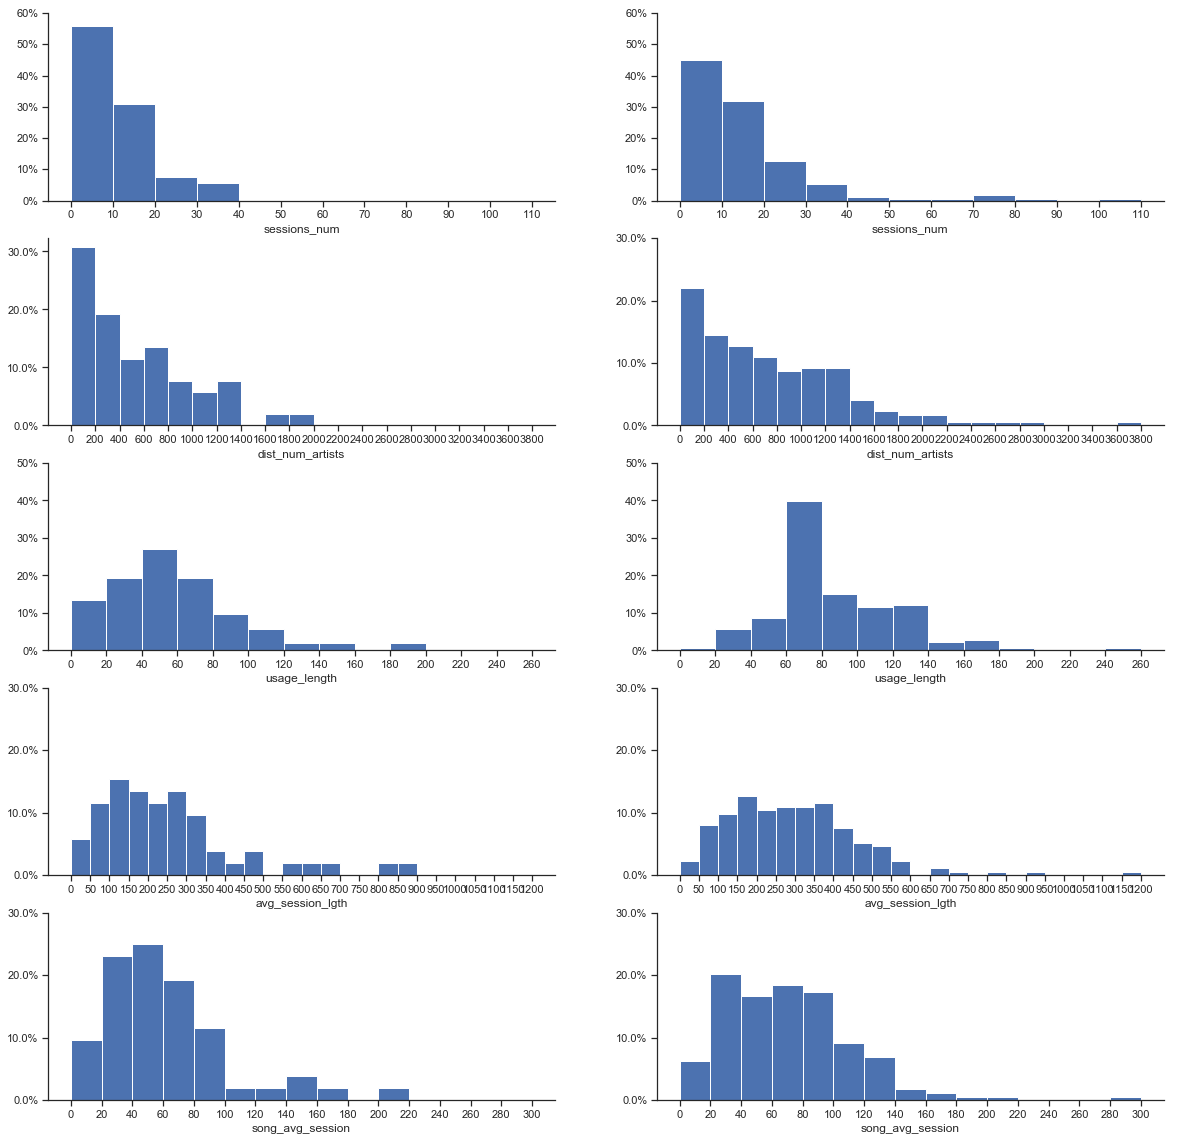

In [98]:
# Plot the most interesting columns as identified above by inspecting median, mean and standard deviation values
cols_1 = ['sessions_num','dist_num_artists', 'usage_length', 'avg_session_lgth', 'song_avg_session']
x_incs_1 = [10, 200, 20, 50, 20]
y_max_1 = [0.6, 0.3, 0.5, 0.2, 0.2]
y_incs_1 = [0.1, 0.1, 0.1, 0.1, 0.1]
plot_features(cols_1, 5, churned_df, not_churned_df, x_inc_list = x_incs_1, y_max_list = y_max_1, y_inc_list = y_incs_1)

Visual inspection of the the relevant features identified confirms the initial hunch that these variables may help us in identifying which users may end up churning.

As the final step, before moving on to the modelling stage, let us have a brief look at the qualitative variables "gender" and "state". 

<Figure size 1440x1080 with 0 Axes>

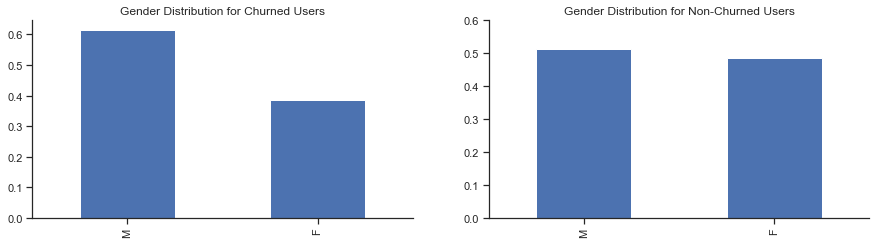

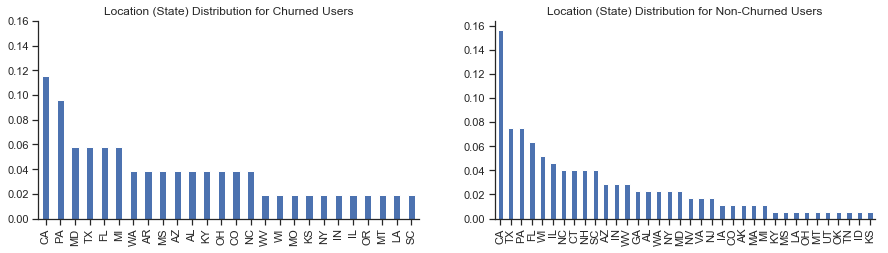

In [119]:
# Create a plot for distribution of gender across the two groups
y_max_list = [0.6, 0.16]
y_inc_list = [0.1, 0.02]
qual_cols = ['gender', 'state']
title_list = ['Gender', 'Location (State)']
base_colour = sns.color_palette()[0]
plt.figure(figsize = (20,15))
j = 0
for i in range(2):
    plt.figure(figsize = (15,8))
    y_max = y_max_list[i]
    y_inc = y_inc_list[i]
    col = qual_cols[i]
    title_colname = title_list[i] 
    
    plt.subplot(2, 2, j+1)
    plt.title(title_colname + ' Distribution for Churned Users')
    churned_df[col].value_counts(normalize = True).plot.bar(x = 'index', y = 'counts', color = sns.color_palette()[0])
    sns.set(style="ticks")
    sns.despine(right=True,top=True)
    plt.yticks(np.arange(0, y_max+y_inc, y_inc))
    
    plt.subplot(2, 2, j+2)
    plt.title(title_colname + ' Distribution for Non-Churned Users')
    not_churned_df[col].value_counts(normalize = True).plot.bar(x = 'index', y = 'counts', color = sns.color_palette()[0])
    sns.set(style="ticks")
    sns.despine(right=True,top=True)
    plt.yticks(np.arange(0, y_max+y_inc, y_inc))
    j+=2

In the graphs above we can observe that the distribution of gender differs noticeably across the two groups. The distribution of the location also seems to differ a bit across the two groups. Hence, both features may potentially help us in predicting whether customers will churn or not.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Modeling
Now that we have identified some promising features, let us just keep these features for our modeling and drop duplicate rows. Since all of these features are aggregate measures, we will end up with a single row for each user by doing so.

We can then proceed to our standard machine learning approach of splitting our dataset into a training, validation and test set. This can then be used on a number of standard classification algorithms to identify which one works best. Finally, we can then optimise the best machine learning algorithm we identified by 

### Imbalanced Dataset
As we have seen above, the share of users who have not churned is more than three times as high as that of those who have churned. In principle we could deal with this by oversampling churned users, but especially in the case of the big data this approach can be problematic. Instead, we can account for this problem by choosing our metric accordingly. With imbalanced classes accuracy would be a bad choice, but if we go for the F1 score instead, we should be able to obtain a good model.

In [ ]:
# Reduce data to what we need for our machine learning algorithm
cols_keep = ['userId', 'sessions_num','dist_num_artists', 'usage_length', 'avg_session_lgth', 'song_avg_session','gender',
             'state']
model_data = user_log.select(*cols_keep).dropDuplicates()

# Perform Tain, Validation, Test Split

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.